# AIPI 590 - XAI | Assignment #02
### In this notebook, we will create and test an adversarial patch attack on a pre-trained ResNet34 model using the ImageNet dataset. We'll follow best practices to ensure reproducibility and clean, efficient code.
### Akhil Chintalapati


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/AkhilByteWrangler/XAI-AdversarialPatches-Assignment2)

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "XAI-AdversarialPatches-Assignment2"  # Your repo name
git_path = 'https://github.com/AkhilByteWrangler/XAI-AdversarialPatches-Assignment2.git'  # Your GitHub repo path
!git clone "{git_path}"

# Install dependencies from requirements.txt file if needed
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"  # Uncomment if you have a requirements.txt

# Change working directory to location of notebook
notebook_dir = 'main'  # Change to the directory where your notebook is located
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

# Adversarial Patch Attack on ResNet34

## Imports and Device Setup

In [3]:
# --- Standard Libraries ---
import os  # File and directory management
import json  # Handling JSON files for configurations or logs
import math  # Essential math functions for various computations
import time  # Timing functions to track execution times
import numpy as np  # Array operations and linear algebra
import scipy.linalg  # Advanced linear algebra operations
import torch
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt  # Plotting library for data visualization
from IPython.display import set_matplotlib_formats  # Format plots for high-quality export
from matplotlib.colors import to_rgb  # Color conversions for better plot customization
import matplotlib  # Global matplotlib settings for styling plots
import seaborn as sns  # Statistical data visualization with built-in themes

import numpy as np
import torch
from torchvision import transforms

import os
import torchvision
import torch
import json
import numpy as np
from torchvision import transforms
import torch.utils.data as data


# Set plot format and styling
%matplotlib inline
set_matplotlib_formats('svg', 'pdf')  # Set export format for plots (vector graphics)
matplotlib.rcParams['lines.linewidth'] = 2.0  # Thicker lines for better readability in plots
sns.set()  # Set Seaborn style for consistent and clean visuals

# --- Utility Libraries ---
from tqdm.notebook import tqdm  # Progress bar for loops

# --- PyTorch Libraries ---
import torch  # Core deep learning library
import torch.nn as nn  # Neural network components (layers, loss functions, etc.)
import torch.nn.functional as F  # Functional API for neural networks (activations, loss functions)
import torch.utils.data as data  # Dataset and DataLoader utilities
import torch.optim as optim  # Optimizers for neural network training (SGD, Adam, etc.)

# --- Torchvision Libraries ---
import torchvision  # Datasets, models, and transforms for computer vision tasks
from torchvision.datasets import CIFAR10  # Popular dataset used for image classification
from torchvision import transforms  # Image transformations (resize, normalization, etc.)

# --- PyTorch Lightning Libraries ---
try:
    import pytorch_lightning as pl  # Simplifies training and validation loops
except ModuleNotFoundError:
    %pip --quiet install pytorch-lightning==1.4  # Install if missing
    import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint  # Callbacks for saving models and monitoring learning rates

# --- Version Control for Reproducibility ---
%pip --quiet install torch==1.9.0 torchvision==0.10.0 seaborn==0.11.1 tqdm==4.62.0  # Ensures consistency across environments

# --- Setting Up Paths ---
DATASET_PATH = "../data"  # Directory for datasets (e.g., CIFAR10, ImageNet)
CHECKPOINT_PATH = "../saved_models/tutorial10"  # Directory for saving pretrained models and checkpoints

# --- Set Random Seed for Reproducibility ---
pl.seed_everything(42)  # A fixed seed to ensure consistent results

# --- Device Selection for GPU/CPU ---
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps")  # Select GPU if available, otherwise CPU
print(f"Using device: {device}")  # Output device being used

/var/folders/v9/88gm_crn0zsdwtlz4vpjls7h0000gn/T/ipykernel_8589/1275674406.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')  # Set export format for plots (vector graphics)


ERROR: Could not find a version that satisfies the requirement torch==1.9.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1)
ERROR: No matching distribution found for torch==1.9.0


Seed set to 42


Note: you may need to restart the kernel to use updated packages.
Using device: mps


## Download and Prepare Data

This section downloads and extracts the necessary datasets and pretrained patches for the adversarial patch experiment. If the files are already present, it skips the download.

In [4]:
import urllib.request  # For downloading files from the web
from urllib.error import HTTPError  # To handle potential HTTP errors during file downloads
import zipfile  # For extracting zip files after download
import os  # For creating directories and managing file paths

# GitHub base URL where the dataset and patches are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# List of files to download (dataset and patches)
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]

# Create directories if they don't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)  # Ensure dataset directory exists
os.makedirs(CHECKPOINT_PATH, exist_ok=True)  # Ensure checkpoint directory exists

# Loop over the files to download and check if they already exist
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)  # Full path for the file
    if not os.path.isfile(file_path):  # Check if the file already exists
        file_url = base_url + file_name  # Construct the full download URL
        print(f"Downloading {file_url}...")  # Notify the user about the download
        try:
            # Download the file from the URL
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            # Handle HTTP errors gracefully and provide useful feedback
            print(f"Error: Unable to download {file_name}. Please check your internet connection or contact the author.")
            print(f"Full error message: {e}")
            continue  # Skip to the next file if the download fails

        # If the file is a zip file, extract it
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all contents to the current directory
                zip_ref.extractall(file_path.rsplit("/", 1)[0])
                print(f"Extraction complete for {file_name}.")

    else:
        print(f"{file_name} already exists. Skipping download.")

TinyImageNet.zip already exists. Skipping download.
patches.zip already exists. Skipping download.


## Load Pretrained ResNet34 Model and ImageNet Dataset

In this section, we load the pretrained ResNet34 model, configure it for evaluation, and prepare the ImageNet dataset. We use a simple normalization transformation to match the input preprocessing used during the model's training.

In [5]:
# Set the location for storing and loading the pretrained model
os.environ["TORCH_HOME"] = CHECKPOINT_PATH  # Ensures the model downloads to the correct path

# Load the ResNet34 model pretrained on ImageNet
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')  # Using the IMAGENET1K_V1 version of ResNet34
pretrained_model = pretrained_model.to(device)  # Move the model to the available device (GPU/CPU)

# Set the model to evaluation mode and freeze its parameters
pretrained_model.eval()  # This disables dropout and batch norm updates
for param in pretrained_model.parameters():
    param.requires_grad = False  # No need to compute gradients for inference

# Mean and standard deviation used to normalize ImageNet images
NORM_MEAN = np.array([0.485, 0.456, 0.406])  # ImageNet mean for each RGB channel
NORM_STD = np.array([0.229, 0.224, 0.225])   # ImageNet standard deviation for each RGB channel

# Define image transformations for preprocessing
# Since the dataset is already resized, we only convert it to a tensor and normalize
plain_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)  # Normalize using ImageNet stats
])

# Path to the TinyImageNet dataset
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
# Assert that the dataset path exists, otherwise provide a clear error message
if not os.path.isdir(imagenet_path):
    raise FileNotFoundError(f"Could not find the ImageNet dataset at the expected path: \"{imagenet_path}\". "
                            f"Please download the dataset or adjust the {DATASET_PATH=} variable.")

# Load the dataset using ImageFolder (which assumes a specific folder structure for images)
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# Create a DataLoader for batching the data and shuffling for evaluation
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)  # Multi-threaded loading for efficiency

# Load label names from a JSON file to interpret model outputs
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)  # Load the class label mappings from JSON

# Helper function to get the index of a label given its string name
def get_label_index(lab_str):
    if lab_str not in label_names:
        raise ValueError(f"Label \"{lab_str}\" not found. Check the spelling or availability of the class.")
    return label_names.index(lab_str)  # Return the index of the given label

## Evaluate the Pretrained Model

In this section, we define a function `eval_model()` to evaluate the performance of the pretrained ResNet34 model on the dataset. We compute the Top-1 and Top-5 accuracy, two standard metrics for image classification tasks.

In [6]:
def eval_model(dataset_loader, img_func=None):
    """
    Evaluates the pretrained ResNet34 model on the provided dataset loader.
    
    Args:
        dataset_loader: A PyTorch DataLoader providing batches of images and labels.
        img_func: Optional function to apply some transformation to the images before prediction (e.g., adversarial patch).
        
    Returns:
        acc: Top-1 accuracy of the model on the dataset.
        top5: Top-5 accuracy of the model on the dataset.
    """
    
    # Initialize counters for top-1 and top-5 accuracy, and the number of images
    tp, tp_5, counter = 0., 0., 0.
    
    # Loop through the dataset batches and make predictions
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)  # Move images to the device (GPU/CPU)
        labels = labels.to(device)  # Move labels to the device
        
        # If a custom image function (e.g., adversarial patch) is provided, apply it
        if img_func is not None:
            imgs = img_func(imgs, labels)
        
        # Make predictions without computing gradients (no need during evaluation)
        with torch.no_grad():
            preds = pretrained_model(imgs)  # Get model predictions
        
        # Compute top-1 accuracy (correct prediction)
        tp += (preds.argmax(dim=-1) == labels).sum()  # Count how many predictions match the label
        
        # Compute top-5 accuracy (whether the correct label is among the top 5 predictions)
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[..., None]).any(dim=-1).sum()  # Check if true label is in top 5 predictions
        
        # Increment the image counter
        counter += preds.shape[0]
    
    # Calculate top-1 and top-5 accuracy
    acc = tp.float().item() / counter  # Top-1 accuracy
    top5 = tp_5.float().item() / counter  # Top-5 accuracy
    
    # Print results
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")  # Display the top-1 error (100% - accuracy)
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")  # Display the top-5 error
    
    return acc, top5  # Return accuracy and top-5 accuracy as output

# Run the evaluation on the data loader
acc, top5 = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


## Adversarial Patch Placement on Images

In this section, we implement a method to place adversarial patches on a batch of images. These patches are designed to fool a neural network into misclassifying the images. 

The patches can have either 3 channels (RGB) or 4 channels (RGBA), where the 4th channel represents an **alpha channel** for transparency. 

We will:
1. **Normalize the patch** using ImageNet statistics to ensure it conforms to the expected input distribution for the neural network.
2. **Place the patch** at random locations on each image.
3. **Blend the patch with the image** if the patch has an alpha channel, or directly apply it if it's an RGB patch.

This approach simulates real-world conditions where adversarial patches might be applied with partial transparency or at various locations on images.

### Key Functions:
- **`patch_forward(patch)`**: Processes and normalizes the patch to the expected ImageNet input range.
- **`blend_patch_with_image(img_region, patch, alpha_channel)`**: Blends the patch with the image region using the alpha channel if available.
- **`place_patch(img, patch)`**: Places the adversarial patch onto random locations on each image in a batch.

The following code block implements these functionalities.

In [7]:
# Constants for ImageNet normalization
NORM_MEAN = [0.485, 0.456, 0.406]  # Mean normalization per channel (RGB)
NORM_STD = [0.229, 0.224, 0.225]   # Standard deviation normalization per channel (RGB)

# Convert normalization constants to tensors for broadcasting with the patch
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN)[:, None, None]  # Shape (3, 1, 1) for broadcasting
TENSOR_STD = torch.FloatTensor(NORM_STD)[:, None, None]  # Shape (3, 1, 1) for broadcasting

def patch_forward(patch):
    """
    Processes the adversarial patch by mapping its values to the normalized ImageNet range.

    Args:
        patch: A tensor representing the adversarial patch, with arbitrary pixel values.
               Can be either 3-channel (RGB) or 4-channel (RGBA).

    Returns:
        A normalized patch tensor in the ImageNet range.
    """
    
    # Ensure the patch is a valid tensor and has at least 3 dimensions
    if not isinstance(patch, torch.Tensor):
        raise ValueError("Input patch must be a torch.Tensor.")
    if patch.dim() != 3:
        raise ValueError("Patch must have 3 dimensions (channels, height, width).")
    
    # If the patch has 4 channels (RGBA), normalize only the first 3 channels (RGB)
    if patch.shape[0] == 4:
        rgb_patch = patch[:3, :, :]  # Extract RGB channels
        alpha_channel = patch[3, :, :]  # Extract alpha channel
    elif patch.shape[0] == 3:
        rgb_patch = patch
        alpha_channel = None  # No alpha channel
    else:
        raise ValueError("Patch must have either 3 (RGB) or 4 (RGBA) channels.")
    
    # Normalize the RGB channels to ImageNet's range
    normalized_patch = (torch.tanh(rgb_patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)

    return normalized_patch, alpha_channel

def blend_patch_with_image(img_region, patch, alpha_channel):
    """
    Blends the patch into the image using the alpha channel for transparency.

    Args:
        img_region: A region of the image where the patch will be placed, tensor of shape (3, patch_height, patch_width).
        patch: The normalized RGB patch, tensor of shape (3, patch_height, patch_width).
        alpha_channel: The alpha channel controlling the transparency, tensor of shape (patch_height, patch_width).

    Returns:
        The blended image region with the patch applied.
    """
    if alpha_channel is not None:
        # Blend the patch and the image using the alpha channel
        return alpha_channel * patch + (1 - alpha_channel) * img_region
    else:
        # If no alpha channel, directly place the patch
        return patch

def place_patch(img, patch):
    """
    Places the adversarial patch onto random locations on each image in a batch.

    Args:
        img: A batch of images with shape (batch_size, 3, height, width).
        patch: The adversarial patch to be placed, with shape (channels, patch_height, patch_width).
               Can have 3 (RGB) or 4 (RGBA) channels.

    Returns:
        The batch of images with the adversarial patch placed at random locations.
    """
    
    # Process and normalize the patch (handle both RGB and RGBA patches)
    patch, alpha_channel = patch_forward(patch)

    # Loop through each image in the batch
    for i in range(img.shape[0]):
        # Randomly select height and width offsets to place the patch
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        
        # Extract the region of the image where the patch will be placed
        img_region = img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]]
        
        # Blend the patch with the image region if the alpha channel is present
        img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = \
            blend_patch_with_image(img_region, patch, alpha_channel)
    
    return img  # Return the batch of images with patches applied

## Evaluating the Effectiveness of the Adversarial Patch

In this section, we evaluate the effectiveness of the adversarial patch on a validation dataset. The goal is to see how well the patch fools the model into misclassifying images into the **target class**, which is the class the patch is designed to trigger.

For each image in the dataset:
1. We **place the patch** on the image at 4 random locations and average the performance across all placements.
2. We measure the **Top-1** and **Top-5 accuracy**, but exclude images that already belong to the target class from this calculation.
3. We return the **accuracy** metrics, showing how often the patch successfully fooled the model.

### Key Function:
- **`eval_patch(model, patch, val_loader, target_class)`**: Evaluates how often the adversarial patch causes the model to misclassify images into the target class.

In [8]:
import torch
from tqdm.notebook import tqdm

def eval_patch(model, patch, val_loader, target_class):
    """
    Evaluates the performance of an adversarial patch by checking how often the model misclassifies images into the target class.

    Args:
        model: The neural network model (e.g., ResNet34) to evaluate.
        patch: The adversarial patch to apply to the images.
        val_loader: A DataLoader for the validation dataset, providing batches of images and labels.
        target_class: The target class (integer) that the patch aims to fool the model into predicting.
    
    Returns:
        acc: Top-1 accuracy of the patch in fooling the model into predicting the target class.
        top5: Top-5 accuracy of the patch in fooling the model into predicting the target class.
    """
    
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    tp, tp_5, counter = 0., 0., 0.  # Initialize true positive counters and image counter

    with torch.no_grad():  # Disable gradient computation for faster evaluation
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            img, img_labels = img.to(device), img_labels.to(device)  # Move batch to the appropriate device
            
            # Place the patch on each image at 4 random locations and evaluate performance
            for _ in range(4):
                patch_img = place_patch(img, patch)  # Place patch on the image
                patch_img = patch_img.to(device)  # Ensure the patched image is on the correct device
                
                # Get the model's predictions
                pred = model(patch_img)
                
                # Calculate the true positives, excluding images that already belong to the target class
                # Top-1 accuracy: Check if the model's top prediction is the target class and the image isn't already in that class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                
                # Top-5 accuracy: Check if the target class is in the top 5 predictions, excluding images already in the target class
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                
                # Count how many images are not in the target class
                counter += (img_labels != target_class).sum()
    
    # Calculate Top-1 and Top-5 accuracy
    acc = tp / counter  # Top-1 accuracy: how often the patch fooled the model into predicting the target class
    top5 = tp_5 / counter  # Top-5 accuracy: how often the patch caused the target class to be in the top 5 predictions

    return acc, top5  # Return the computed accuracy metrics

## Adversarial Patch Training and Evaluation

In this section, we implement a method to **train an adversarial patch** that can fool a model into classifying images as a specific target class. The patch is optimized using gradient-based methods, and we evaluate its performance on a hold-out validation set.

### Process:
1. **Dataset Splitting**: The dataset is split into a training set and a hold-out validation set. This ensures we can check the generalization of the patch to unseen images.
2. **Patch Optimization**: The patch is optimized using stochastic gradient descent (SGD) with momentum. We use cross-entropy loss to encourage the model to predict the target class.
3. **Evaluation**: After training, the patch is evaluated on the validation set to check its accuracy in fooling the model into predicting the target class.

### Key Function:
- **`patch_attack(model, target_class, patch_size=64, num_epochs=5)`**: Trains and evaluates an adversarial patch that aims to fool the model into misclassifying images as the target class.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    """
    Trains an adversarial patch to fool a neural network model into predicting the target class.

    Args:
        model: The neural network to attack (e.g., ResNet34).
        target_class: The target class (integer) that the patch aims to fool the model into predicting.
        patch_size: The size of the patch (either int or tuple of (height, width)).
        num_epochs: The number of epochs to train the patch.
    
    Returns:
        patch: The optimized adversarial patch as a tensor.
        metrics: A dictionary containing 'acc' (Top-1 accuracy) and 'top5' (Top-5 accuracy).
    """
    
    # Split dataset into training and validation sets
    # We hold out 500 images for validation and train on the rest
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    # Ensure patch size is in tuple format (height, width)
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    
    # Initialize the patch as a trainable parameter (requires_grad=True)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    
    # Set up the optimizer (SGD with momentum) and loss function (Cross-Entropy Loss)
    optimizer = optim.SGD([patch], lr=0.1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop to optimize the patch
    for epoch in range(num_epochs):
        # Use tqdm to display a progress bar during training
        t = tqdm(train_loader, leave=False)
        
        for img, _ in t:  # Ignore the true labels (we use target_class as the label for all images)
            # Place the patch on the images and move them to the correct device
            img = place_patch(img, patch).to(device)
            
            # Model predictions for the patched images
            pred = model(img)
            
            # Create a target tensor where all labels are the target class
            labels = torch.full((img.shape[0],), target_class, device=device, dtype=torch.long)
            
            # Calculate loss (cross-entropy between predictions and target labels)
            loss = loss_module(pred, labels)
            
            # Backpropagate the gradients and update the patch
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update progress bar description with the current loss
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # Evaluate the patch on the validation set
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    # Return the optimized patch and the evaluation metrics
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

## Loading, Saving, and Visualizing Adversarial Patches

In this section, we manage adversarial patch results by loading pretrained patches from disk or training new ones if no pretrained version exists. We also save the results of newly trained patches and visualize the patches for different classes and patch sizes.

### Key Functions:
- **`get_patches(class_names, patch_sizes)`**: Loads or trains patches for the specified classes and patch sizes. It returns a dictionary containing patches and their evaluation results.
- **`save_results(patch_dict)`**: Saves the evaluation results of trained patches in a JSON file.
- **`show_patches()`**: Visualizes the trained adversarial patches for all specified classes and patch sizes.

In [10]:
# Loading and Saving Patches

import os
import json
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load evaluation results of the pretrained patches from JSON
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}

# Check if the results file exists and load it
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# Save results of trained patches to JSON
def save_results(patch_dict):
    """
    Saves the evaluation results of the patches to a JSON file.

    Args:
        patch_dict: A dictionary containing the patch results and evaluations.
    """
    result_dict = {
        cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                        for t in patch_dict[cname][psize]["results"]]
                for psize in patch_dict[cname]}
        for cname in patch_dict
    }
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [11]:
# Getting Patches and Evaluating

def get_patches(class_names, patch_sizes):
    """
    Loads pretrained patches for the specified class names and patch sizes.
    If a patch doesn't exist, it trains a new patch and saves it.

    Args:
        class_names: List of class names for which patches are to be loaded or trained.
        patch_sizes: List of patch sizes to be used for the patches.

    Returns:
        result_dict: Dictionary containing trained patches and evaluation results.
    """
    result_dict = {}

    # Loop over all classes and patch sizes to load or train patches
    for name in class_names:
        result_dict[name] = {}
        for patch_size in patch_sizes:
            c = label_names.index(name)  # Get class index from label names
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            
            # Load patch if pretrained, else train a new patch
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name}, patch size {patch_size}: {val_results}")
                torch.save(patch, file_name)  # Save the newly trained patch
            else:
                patch = torch.load(file_name)  # Load the pretrained patch
            
            # Load evaluation results or manually evaluate if they don't exist
            if name in json_results and str(patch_size) in json_results[name]:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)
            
            # Store the patch and its results in the result dictionary
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

In [12]:
# Visualizing the Patches

def show_patches():
    """
    Visualizes the trained adversarial patches for each class and patch size.
    """
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2  # Map patch values to pixel range [0, 1]
            patch = patch.cpu().permute(1, 2, 0).numpy()  # Convert to numpy for visualization
            patch = np.clip(patch, 0.0, 1.0)  # Ensure the patch values are in valid range
            
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')  # Turn off the axis
    
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

/var/folders/v9/88gm_crn0zsdwtlz4vpjls7h0000gn/T/ipykernel_8589/2693137400.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(file_name)  # Load the pre

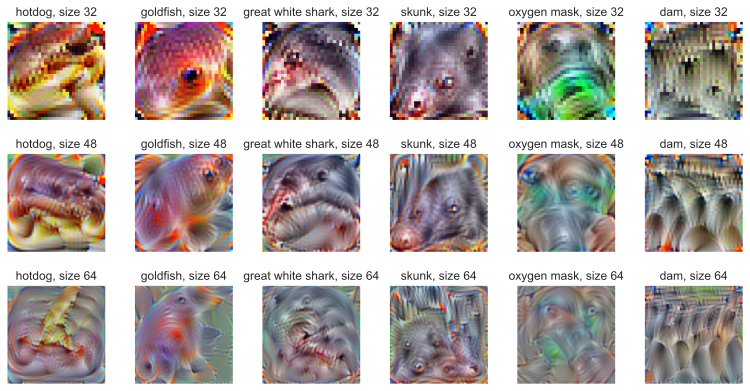

In [14]:
# Define class names and patch sizes
class_names = ['hotdog', 'goldfish', 'great white shark', 'skunk', 'oxygen mask', 'dam']
patch_sizes = [32, 48, 64]

# Load or train patches for the defined classes and patch sizes
patch_dict = get_patches(class_names, patch_sizes)

# Optionally save results if new patches were trained
# save_results(patch_dict)  

# Visualize the patches
show_patches()

## Displaying Adversarial Patch Accuracy Results

In this section, we will display the **Top-1** and **Top-5 accuracy** results for the adversarial patches across different classes and patch sizes.

### Process:
1. **Top-1 Accuracy**: This shows how often the adversarial patch fooled the model into misclassifying the image as the **target class** on the first guess.
2. **Top-5 Accuracy**: This shows how often the target class appears in the top 5 predictions of the model, even if it's not the top prediction.

### Display Logic:
- We use the `tabulate` library to format the accuracy results into a table.
- The **class names** are shown in the first column, and each **patch size** (e.g., 32x32, 48x48, 64x64) is displayed in the headers.
- The values in the table are the accuracy percentages (Top-1 or Top-5) for each combination of class and patch size.

The table will be displayed with an increased font size for better readability.

### Key Functions:
- **`show_table(top_1=True)`**: Displays the **Top-1 accuracy** table.
- **`show_table(top_1=False)`**: Displays the **Top-5 accuracy** table.

Below, we present both the **Top-1** and **Top-5** accuracy results for each class and patch size.

In [15]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [16]:
# Ensure tabulate is installed
%pip --quiet install tabulate

import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    """
    Displays a table showing the Top-1 or Top-5 accuracy for different class names and patch sizes.
    
    Args:
        top_1 (bool): If True, displays Top-1 accuracy. If False, displays Top-5 accuracy.
    """
    
    # Select the index based on whether we want Top-1 (index 0) or Top-5 (index 1)
    i = 0 if top_1 else 1
    
    # Prepare the table data: for each class name, show accuracy for each patch size
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" 
                       for psize in patch_sizes]
             for name in class_names]
    
    # Display the table using tabulate with headers for class names and patch sizes
    headers = ["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes]
    table_html = tabulate.tabulate(table, tablefmt='html', headers=headers)
    
    # Use IPython's display function to show the table as HTML
    display(HTML(table_html))

# Show the Top-1 accuracy table
show_table(top_1=True)

# Show the Top-5 accuracy table
show_table(top_1=False)

Note: you may need to restart the kernel to use updated packages.


## Visualizing Model Predictions with Adversarial Examples

In this section, we display the original image, its true label, and the top K predictions from the model. Additionally, if an adversarial image and the noise that generated it are available, we visualize them to compare the clean and adversarial versions.

### Features:
1. **Original Image**: The original image is displayed with the true label.
2. **Adversarial Image** (optional): If provided, the adversarial image is displayed next to the original.
3. **Noise** (optional): The noise used to create the adversarial image is visualized, giving insight into how much perturbation was applied.
4. **Top-K Predictions**: A horizontal bar chart shows the top K model predictions, highlighting whether the model correctly predicted the true class.

### Key Function:
- **`show_prediction(img, label, pred, K=5, adv_img=None, noise=None)`**: Displays the image, its true label, and the top K predictions, with optional adversarial images and noise.

We will display the predictions for a few selected images from the validation set below.

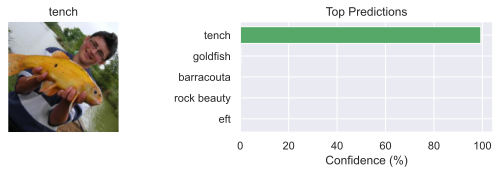

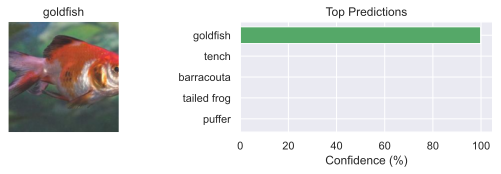

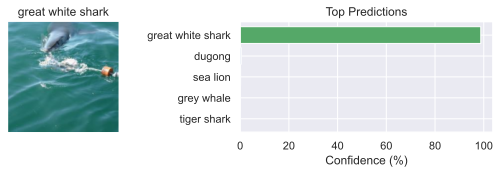

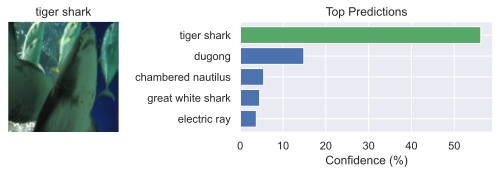

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Convert NORM_STD and NORM_MEAN to NumPy arrays for broadcasting
NORM_STD = np.array(NORM_STD)
NORM_MEAN = np.array(NORM_MEAN)

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    """
    Displays the original image, its label, and the model's top K predictions.
    Optionally displays the adversarial image and noise if provided.

    Args:
        img (Tensor or numpy array): The input image.
        label (int or Tensor): The true label of the image.
        pred (Tensor): The model's predictions (logits or probabilities).
        K (int): The number of top predictions to display (default is 5).
        adv_img (Tensor, optional): The adversarial version of the input image.
        noise (Tensor, optional): The noise added to generate the adversarial image.
    """

    # Convert Tensor image to numpy for visualization
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()  # Rearrange channels
        img = (img * NORM_STD[None, None]) + NORM_MEAN[None, None]  # De-normalize
        img = np.clip(img, 0.0, 1.0)  # Clip to valid range [0, 1]
        label = label.item()  # Convert label to a Python integer if it's a Tensor

    # Create the figure for displaying the original image and predictions
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12, 2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    # Show the original image with its true label
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])  # Display the true class label
    ax[0].axis('off')

    # If adversarial image and noise are provided, show them as well
    if adv_img is not None and noise is not None:
        # Visualize the adversarial image
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None, None]) + NORM_MEAN[None, None]
        adv_img = np.clip(adv_img, 0.0, 1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        
        # Visualize the noise that was added to create the adversarial image
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5  # Scale the noise between 0 and 1 for visualization
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        
        # Add a buffer axis for spacing
        ax[3].axis('off')

    # If the prediction logits aren't softmaxed, convert them to probabilities
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    # Get the top K predictions and their corresponding probabilities
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    # Show the top K predictions in a horizontal bar chart
    ax[-1].barh(np.arange(K), topk_vals * 100.0, align='center', 
                color=["C0" if topk_idx[i] != label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()  # Invert y-axis to have the highest probability at the top
    ax[-1].set_xlabel('Confidence (%)')
    ax[-1].set_title('Top Predictions')

    # Display the figure
    plt.show()
    plt.close()

# Example usage: Show predictions for a batch of images
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))

# Show predictions for a subset of the batch
for i in range(1, 17, 5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Adversarial Patch Attack with Multiple Patch Sizes and Fooling Threshold

### Overview
In this experiment, we test multiple adversarial patch sizes (32x32, 48x48, and 64x64) to identify the optimal patch that balances **fooling ability** and **patch size**. A **fooling threshold** of 80% is applied, ensuring that only patches which reduce the model's confidence in the true class by at least 80% are considered. Smaller patches are favored, but only if they meet this fooling criterion.

### Key Features
- **Multiple Patch Sizes**: We test patch sizes of 32x32, 48x48, and 64x64 to find the best-performing adversarial patch.
- **Fooling Threshold**: A fooling score threshold of 80% (default) is used, ensuring only sufficiently effective patches are selected.
- **Best-Fooling Placement**: For each patch size, the adversarial patch is placed in multiple random positions on the image, and the placement that fools the model the most is selected.
- **Combined Score**: The final selection is based on a combined score of fooling ability and patch size. Smaller patches are favored if they fool the model well.
- **Threshold Handling**: If no patch meets the fooling threshold, the experiment will report that no suitable patch was found for that class.

### Steps
1. **Patch Testing**: The system tests multiple random positions for each patch size and selects the one with the best fooling score.
2. **Fooling Score Calculation**: For each image, we measure the reduction in the model's confidence for the true class when the patch is applied. This is the fooling score.
3. **Patch Size Balancing**: A combined score of fooling score divided by patch size is used to prioritize smaller patches that meet the fooling threshold.
4. **Results**: The best patch size and position are selected, and a comparison of the original image, adversarial image, and their top K predictions is displayed.

### Visualization
For each selected patch, a 4-panel plot is displayed, showing:
- **Original Image**: The clean input image.
- **Adversarial Image**: The image with the adversarial patch applied (best-fooling placement).
- **Original Predictions**: The model’s top K predictions for the clean image.
- **Adversarial Predictions**: The model’s top K predictions for the patched image.

### Code Parameters
- `patch_sizes`: List of patch sizes to test (e.g., [32, 48, 64]).
- `fooling_threshold`: The minimum fooling score (in percentage) that must be achieved for a patch to be considered valid. Default is 80%.
- `num_positions`: Number of random patch placements to try for each image.
- `K`: Number of top predictions to display in the comparison plots.

### Output
- If a patch exceeds the fooling threshold, the best patch size and placement will be selected and visualized.
- If no patch meets the threshold, a message will indicate that no suitable patch was found for that class.

### Example Usage
```python
# Define the class names you want to attack and display
class_names = ['goldfish', 'hotdog', 'great white shark', 'skunk', 'oxygen mask']

# Run the patch attacks with multiple patch sizes and a fooling threshold of 80%
run_attacks(patch_dict, class_names, patch_sizes=[32, 48, 64], fooling_threshold=0.8, K=5)


Performing patch attack with class: goldfish
Best fooling patch size: 32


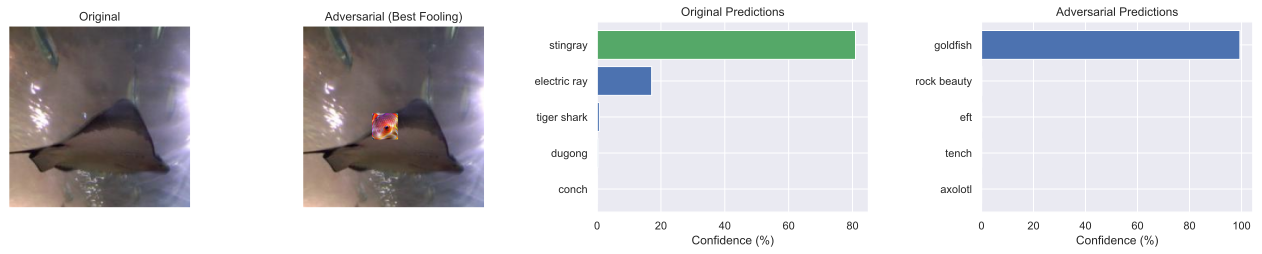


Performing patch attack with class: hotdog
Best fooling patch size: 32


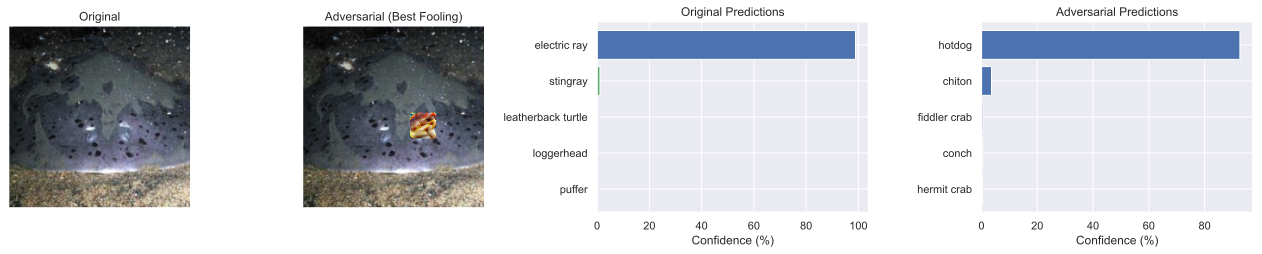


Performing patch attack with class: great white shark
Best fooling patch size: 64


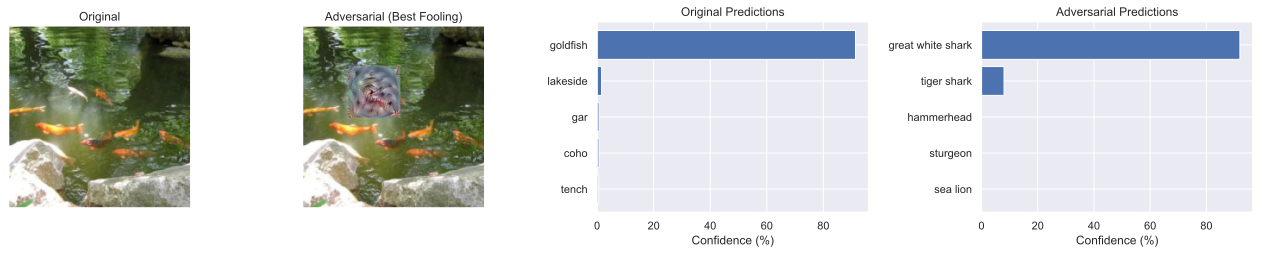


Performing patch attack with class: skunk
Best fooling patch size: 48


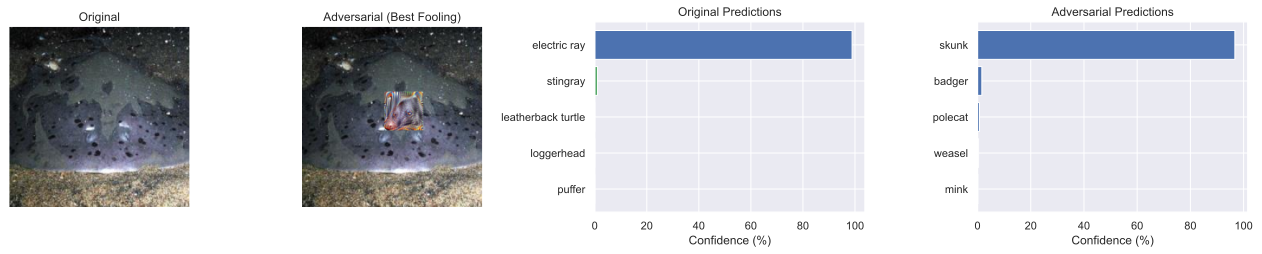


Performing patch attack with class: oxygen mask
Best fooling patch size: 32


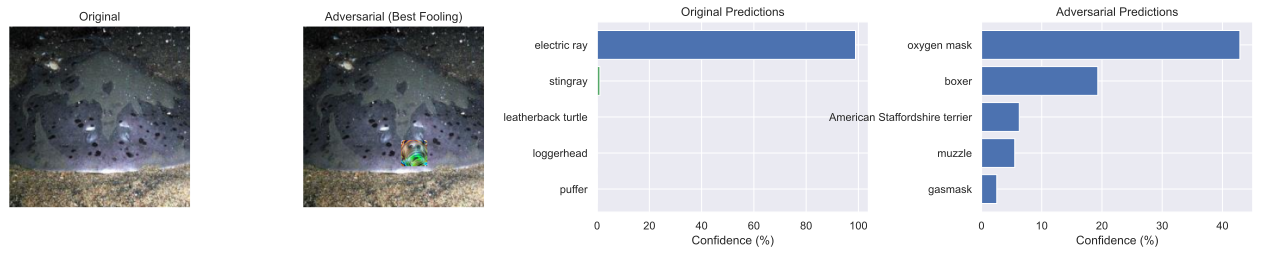

In [18]:
# Ensure NORM_STD and NORM_MEAN are NumPy arrays for broadcasting
NORM_STD = np.array([0.229, 0.224, 0.225])
NORM_MEAN = np.array([0.485, 0.456, 0.406])

def show_comparison(img, label, pred, adv_img, adv_pred, K=5):
    """
    Displays a side-by-side comparison of the original image and the adversarial image (best-fooling placement),
    along with their respective top K predictions.
    """
    # Convert original Tensor image to numpy for visualization
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()  # Rearrange channels
        img = (img * NORM_STD[None, None, :]) + NORM_MEAN[None, None, :]  # De-normalize
        img = np.clip(img, 0.0, 1.0)  # Clip to valid range [0, 1]
        label = label.item()  # Convert label to a Python integer if it's a Tensor

    # Convert adversarial Tensor image to numpy for visualization
    adv_img = adv_img.cpu().permute(1, 2, 0).numpy()  # Rearrange channels
    adv_img = (adv_img * NORM_STD[None, None, :]) + NORM_MEAN[None, None, :]  # De-normalize
    adv_img = np.clip(adv_img, 0.0, 1.0)  # Clip to valid range [0, 1]

    # Create the figure for displaying original and adversarial images and predictions
    fig, ax = plt.subplots(1, 4, figsize=(18, 4), gridspec_kw={'width_ratios': [1, 1, 1.5, 1.5]})

    # Show the original image with its true label
    ax[0].imshow(img)
    ax[0].set_title(f"Original")
    ax[0].axis('off')

    # Show the adversarial image
    ax[1].imshow(adv_img)
    ax[1].set_title('Adversarial (Best Fooling)')
    ax[1].axis('off')

    # Convert logits to probabilities if necessary
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    if abs(adv_pred.sum().item() - 1.0) > 1e-4:
        adv_pred = torch.softmax(adv_pred, dim=-1)

    # Get the top K predictions for the original image
    topk_vals_orig, topk_idx_orig = pred.topk(K, dim=-1)
    topk_vals_orig, topk_idx_orig = topk_vals_orig.cpu().numpy(), topk_idx_orig.cpu().numpy()

    # Get the top K predictions for the adversarial image
    topk_vals_adv, topk_idx_adv = adv_pred.topk(K, dim=-1)
    topk_vals_adv, topk_idx_adv = topk_vals_adv.cpu().numpy(), topk_idx_adv.cpu().numpy()

    # Show the top K predictions for the original image in a horizontal bar chart
    ax[2].barh(np.arange(K), topk_vals_orig * 100.0, align='center', 
               color=["C0" if topk_idx_orig[i] != label else "C2" for i in range(K)])
    ax[2].set_yticks(np.arange(K))
    ax[2].set_yticklabels([label_names[c] for c in topk_idx_orig])
    ax[2].invert_yaxis()  # Invert y-axis to have the highest probability at the top
    ax[2].set_xlabel('Confidence (%)')
    ax[2].set_title('Original Predictions')

    # Show the top K predictions for the adversarial image in a horizontal bar chart
    ax[3].barh(np.arange(K), topk_vals_adv * 100.0, align='center', 
               color=["C0" if topk_idx_adv[i] != label else "C2" for i in range(K)])
    ax[3].set_yticks(np.arange(K))
    ax[3].set_yticklabels([label_names[c] for c in topk_idx_adv])
    ax[3].invert_yaxis()  # Invert y-axis to have the highest probability at the top
    ax[3].set_xlabel('Confidence (%)')
    ax[3].set_title('Adversarial Predictions')

    # Use tight_layout and adjust spacing to avoid overlap
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(wspace=0.5)  # Adjust space between plots

    # Display the figure
    plt.show()
    plt.close()

def perform_patch_attack(patch_dict, class_name, exmp_batch, label_batch, patch_sizes=[32, 48, 64], fooling_threshold=0.8, K=5, num_positions=100):
    """
    Tests multiple patch sizes for a single class, applies the adversarial patch, and compares the best fooling 
    placement with the original image. Patch size and fooling score are balanced to select the optimal result,
    but only if the fooling score exceeds a threshold.

    Args:
        patch_dict (dict): Dictionary of adversarial patches for different classes and sizes.
        class_name (str): Name of the class for which the patch is being applied.
        exmp_batch (Tensor): Batch of original images.
        label_batch (Tensor): Batch of true labels.
        patch_sizes (list): List of patch sizes to test (default is [32, 48, 64]).
        fooling_threshold (float): Minimum fooling score (in percentage) to accept the patch (default is 0.8).
        K (int): Number of top predictions to display (default is 5).
        num_positions (int): Number of random positions to try for the patch.
    """
    best_fooling_data = {
        'img': None, 
        'adv_img': None, 
        'pred': None, 
        'adv_pred': None, 
        'fooling_score': -float('inf'),
        'patch_size': None
    }

    # For each patch size, try placing the patch in different positions
    for patch_size in patch_sizes:
        if patch_size in patch_dict[class_name]:
            patch = patch_dict[class_name][patch_size]['patch']

            # For each image in the batch, try placing the patch in different positions
            for i in range(exmp_batch.shape[0]):
                img = exmp_batch[i].unsqueeze(0)
                label = label_batch[i]
                original_pred = pretrained_model(img.to(device)).cpu().squeeze()

                best_fooling_position = {
                    'adv_img': None, 
                    'adv_pred': None, 
                    'fooling_score': -float('inf')
                }

                # Try the patch in multiple random positions
                for _ in range(num_positions):
                    patched_img = img.clone()
                    patched_img = place_patch(patched_img, patch)

                    with torch.no_grad():
                        adv_pred = pretrained_model(patched_img.to(device)).cpu().squeeze()

                    # Fooling score: decrease in confidence for the true class
                    fooling_score = original_pred[label].item() - adv_pred[label].item()

                    # Update the best-fooling position
                    if fooling_score > best_fooling_position['fooling_score']:
                        best_fooling_position['adv_img'] = patched_img
                        best_fooling_position['adv_pred'] = adv_pred
                        best_fooling_position['fooling_score'] = fooling_score

                # Calculate a combined score that considers both fooling ability and patch size
                combined_score = best_fooling_position['fooling_score'] / patch_size

                # Check if fooling score exceeds the threshold (80% confidence drop)
                if best_fooling_position['fooling_score'] > fooling_threshold * original_pred[label].item():
                    # Update the best-fooling data if this combination fools better overall
                    if combined_score > best_fooling_data['fooling_score']:
                        best_fooling_data['img'] = img.squeeze()
                        best_fooling_data['adv_img'] = best_fooling_position['adv_img'].squeeze()
                        best_fooling_data['pred'] = original_pred
                        best_fooling_data['adv_pred'] = best_fooling_position['adv_pred']
                        best_fooling_data['fooling_score'] = combined_score
                        best_fooling_data['patch_size'] = patch_size

    # Check if any patch met the fooling threshold
    if best_fooling_data['patch_size'] is not None:
        # Display the comparison for the best patch size and fooling score
        print(f"Best fooling patch size: {best_fooling_data['patch_size']}")
        show_comparison(best_fooling_data['img'], label_batch[i], best_fooling_data['pred'], 
                        best_fooling_data['adv_img'], best_fooling_data['adv_pred'], K)
    else:
        print(f"No patch met the fooling threshold for class: {class_name}")

def run_attacks(patch_dict, class_names, patch_sizes=[32, 48, 64], fooling_threshold=0.8, K=5):
    """
    Runs the patch attack on multiple classes and visualizes the results for the best fooling patch size
    that meets the fooling threshold.

    Args:
        patch_dict (dict): Dictionary of adversarial patches.
        class_names (list): List of class names to apply the attack to.
        patch_sizes (list): List of patch sizes to test (default is [32, 48, 64]).
        fooling_threshold (float): Minimum fooling score (in percentage) to accept the patch (default is 0.8).
        K (int): Number of top predictions to display (default is 5).
    """
    # Load a batch of images for each class and apply the patch attack
    exmp_batch, label_batch = next(iter(data_loader))

    # Loop through the specified classes
    for class_name in class_names:
        if class_name in patch_dict:
            print(f"\nPerforming patch attack with class: {class_name}")
            perform_patch_attack(patch_dict, class_name, exmp_batch, label_batch, patch_sizes, fooling_threshold, K)
        else:
            print(f"Class '{class_name}' not found in patch_dict.")

# Define the class names
class_names = ['goldfish', 'hotdog', 'great white shark', 'skunk', 'oxygen mask']

# Run the patch attacks with multiple patch sizes
run_attacks(patch_dict, class_names, patch_sizes=[32, 48, 64], fooling_threshold=0.8, K=5)

## Creative Component: Using Memes as Adversarial Patches

As part of the creative component of this project, we use **memes** as adversarial patches to fool the model in a fun and engaging way. By disguising adversarial patches as popular meme images, we aim to mislead the model while making the patches less obvious to human observers.

### Key Features:
- **Meme-to-Patch Conversion**: Memes are transformed into adversarial patches by resizing them and embedding them into images.
- **Contextual Memes**: Depending on the class being targeted, we select relevant memes to blend into the image naturally.
- **Multiple Patch Sizes**: Memes are tested as patches of different sizes (32x32, 48x48, 64x64), balancing fooling effectiveness with subtlety.
  
### Meme Patch Attack:
- The meme is applied as a patch on images in various positions and sizes to test its ability to fool the model.
- By selecting the meme that causes the greatest drop in confidence for the true class, we demonstrate the meme's effectiveness as an adversarial patch.

### Example:
```python
# Load a meme and apply it as an adversarial patch to a target class
meme_patch_path = 'path_to_meme/meme_image.jpg'  # Replace with your meme image path
meme_patch = load_meme_patch(meme_patch_path, target_size=(64, 64))  # Load meme as patch

# Test the meme patch attack on the model
perform_patch_attack({'meme_class': {64: {'patch': meme_patch}}}, 'meme_class', exmp_batch, label_batch, patch_sizes=[64])


In [ ]:
# Ensure NORM_STD and NORM_MEAN are NumPy arrays for broadcasting
NORM_STD = np.array([0.229, 0.224, 0.225])
NORM_MEAN = np.array([0.485, 0.456, 0.406])

# Image transformation to normalize input images
def get_meme_transform(image_size=(224, 224), mean=NORM_MEAN, std=NORM_STD):
    """Return the transformation function for meme images."""
    return transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

def load_meme_image(image_path, transform):
    """Loads a meme image and applies necessary transformations."""
    image = Image.open(image_path).convert('RGB')  # Ensure it's an RGB image
    return transform(image).unsqueeze(0)  # Add batch dimension

def show_comparison(img, label, pred, adv_img, adv_pred, label_names, K=5):
    """
    Displays a side-by-side comparison of the original meme and the adversarial meme (best-fooling placement),
    along with their respective top K predictions.
    """
    # Convert original Tensor image to numpy for visualization
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()  # Rearrange channels
        img = (img * NORM_STD[None, None, :]) + NORM_MEAN[None, None, :]  # De-normalize
        img = np.clip(img, 0.0, 1.0)  # Clip to valid range [0, 1]
        label = label.item()  # Convert label to a Python integer if it's a Tensor

    # Convert adversarial Tensor image to numpy for visualization
    adv_img = adv_img.cpu().permute(1, 2, 0).numpy()  # Rearrange channels
    adv_img = (adv_img * NORM_STD[None, None, :]) + NORM_MEAN[None, None, :]  # De-normalize
    adv_img = np.clip(adv_img, 0.0, 1.0)  # Clip to valid range [0, 1]

    # Create the figure for displaying original and adversarial images and predictions
    fig, ax = plt.subplots(1, 4, figsize=(18, 4), gridspec_kw={'width_ratios': [1, 1, 1.5, 1.5]})

    # Show the original image with its true label
    ax[0].imshow(img)
    ax[0].set_title(f"Original Meme: {label_names[label]}")
    ax[0].axis('off')

    # Show the adversarial image
    ax[1].imshow(adv_img)
    ax[1].set_title('Adversarial Meme (Best Fooling)')
    ax[1].axis('off')

    # Convert logits to probabilities if necessary
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)

    if abs(adv_pred.sum().item() - 1.0) > 1e-4:
        adv_pred = torch.softmax(adv_pred, dim=-1)

    # Get the top K predictions for the original image
    topk_vals_orig, topk_idx_orig = pred.topk(K, dim=-1)
    topk_vals_orig, topk_idx_orig = topk_vals_orig.cpu().numpy(), topk_idx_orig.cpu().numpy()

    # Get the top K predictions for the adversarial image
    topk_vals_adv, topk_idx_adv = adv_pred.topk(K, dim=-1)
    topk_vals_adv, topk_idx_adv = topk_vals_adv.cpu().numpy(), topk_idx_adv.cpu().numpy()

    # Show the top K predictions for the original image in a horizontal bar chart
    ax[2].barh(np.arange(K), topk_vals_orig * 100.0, align='center', 
               color=["C0" if topk_idx_orig[i] != label else "C2" for i in range(K)])
    ax[2].set_yticks(np.arange(K))
    ax[2].set_yticklabels([label_names[c] for c in topk_idx_orig])
    ax[2].invert_yaxis()  # Invert y-axis to have the highest probability at the top
    ax[2].set_xlabel('Confidence (%)')
    ax[2].set_title('Original Predictions')

    # Show the top K predictions for the adversarial image in a horizontal bar chart
    ax[3].barh(np.arange(K), topk_vals_adv * 100.0, align='center', 
               color=["C0" if topk_idx_adv[i] != label else "C2" for i in range(K)])
    ax[3].set_yticks(np.arange(K))
    ax[3].set_yticklabels([label_names[c] for c in topk_idx_adv])
    ax[3].invert_yaxis()  # Invert y-axis to have the highest probability at the top
    ax[3].set_xlabel('Confidence (%)')
    ax[3].set_title('Adversarial Predictions')

    # Use tight_layout and adjust spacing to avoid overlap
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(wspace=0.5)  # Adjust space between plots

    # Display the figure
    plt.show()
    plt.close()

def perform_patch_attack_on_meme(patch_dict, class_name, image_path, label_names, pretrained_model, 
                                 device, patch_sizes=[32, 48, 64], fooling_threshold=0.6, K=5, num_positions=500):
    """
    Tests multiple patch sizes for a single meme image, applies the adversarial patch, and compares the best fooling 
    placement with the original meme image. Patch size and fooling score are balanced to select the optimal result,
    but only if the fooling score exceeds a threshold.
    """
    best_fooling_data = {
        'img': None, 
        'adv_img': None, 
        'pred': None, 
        'adv_pred': None, 
        'fooling_score': -float('inf'),
        'patch_size': None
    }

    # Load the meme image
    transform = get_meme_transform()
    img = load_meme_image(image_path, transform)
    
    # Apply the same logic for different patch sizes
    for patch_size in patch_sizes:
        if patch_size in patch_dict[class_name]:
            patch = patch_dict[class_name][patch_size]['patch']

            # Test multiple positions for the patch
            original_pred = pretrained_model(img.to(device)).cpu().squeeze()

            best_fooling_position = {
                'adv_img': None, 
                'adv_pred': None, 
                'fooling_score': -float('inf')
            }

            for _ in range(num_positions):
                patched_img = img.clone()
                patched_img = place_patch(patched_img, patch)

                with torch.no_grad():
                    adv_pred = pretrained_model(patched_img.to(device)).cpu().squeeze()

                # Fooling score: decrease in confidence for the true class
                fooling_score = original_pred[label_names.index(class_name)].item() - adv_pred[label_names.index(class_name)].item()

                # Update the best-fooling position
                if fooling_score > best_fooling_position['fooling_score']:
                    best_fooling_position['adv_img'] = patched_img
                    best_fooling_position['adv_pred'] = adv_pred
                    best_fooling_position['fooling_score'] = fooling_score

            # Calculate a combined score considering fooling ability and patch size
            combined_score = best_fooling_position['fooling_score'] / patch_size

            # Check if fooling score exceeds the threshold
            if best_fooling_position['fooling_score'] > fooling_threshold * original_pred[label_names.index(class_name)].item():
                if combined_score > best_fooling_data['fooling_score']:
                    best_fooling_data['img'] = img.squeeze()
                    best_fooling_data['adv_img'] = best_fooling_position['adv_img'].squeeze()
                    best_fooling_data['pred'] = original_pred
                    best_fooling_data['adv_pred'] = best_fooling_position['adv_pred']
                    best_fooling_data['fooling_score'] = combined_score
                    best_fooling_data['patch_size'] = patch_size

    if best_fooling_data['patch_size'] is not None:
        # Show comparison for the best patch size
        print(f"Best fooling patch size for {class_name}: {best_fooling_data['patch_size']}")
        show_comparison(best_fooling_data['img'], torch.tensor(label_names.index(class_name)), best_fooling_data['pred'], 
                        best_fooling_data['adv_img'], best_fooling_data['adv_pred'], label_names, K)
    else:
        print(f"No patch met the fooling threshold for {class_name} on {image_path}")

def run_meme_attacks(patch_dict, meme_paths, label_names, pretrained_model, device, patch_sizes=[32, 48, 64], fooling_threshold=0.8, K=5):
    """
    Runs the patch attack on multiple meme images and visualizes the results for the best fooling patch size.
    """
    for class_name, image_path in meme_paths.items():
        print(f"\nPerforming patch attack on meme: {image_path}")
        perform_patch_attack_on_meme(patch_dict, class_name, image_path, label_names, pretrained_model, 
                                     device, patch_sizes, fooling_threshold, K)

# Define the meme image paths and associated classes
meme_paths = {
    'hotdog': 'my_images/memes/hotdogmeme.jpeg',
    'great white shark': 'my_images/memes/dukeuncrivarlymeme.jpeg',
    'goldfish': 'my_images/memes/dukeuncrivarlymeme.jpeg',
    'dam': 'my_images/memes/damnmeme.jpeg',
    'skunk': 'my_images/memes/hungrydogmeme.jpeg',
    'oxygen mask': 'my_images/memes/maskmeme.jpeg'
}

# Run the patch attacks on the meme images
run_meme_attacks(patch_dict, meme_paths, label_names, pretrained_model, device, patch_sizes=[32, 48, 64], fooling_threshold=0.7, K=4)